In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [2]:
from env import host, user, password

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [3]:
url = get_db_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
# Cluster on all or a selected subset of features
grocery_milk_fresh = df[["Grocery", "Milk", "Fresh"]]
grocery_milk_fresh.head(2)

,Grocery,Milk,Fresh
customer_id,,,
0,7561,9656,12669
1,9568,9810,7057


In [5]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(grocery_milk_fresh)

# Use the scaler
grocery_milk_fresh = scaler.transform(grocery_milk_fresh)
grocery_milk_fresh

array([[0.08146416, 0.13072723, 0.11294004],
       [0.10309667, 0.13282409, 0.06289903],
       [0.08278992, 0.11918086, 0.05662161],
       ...,
       [0.32594285, 0.21013575, 0.1295431 ],
       [0.02402535, 0.02622442, 0.091727  ],
       [0.02702178, 0.02237109, 0.02482434]])

In [6]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(grocery_milk_fresh)

DBSCAN(eps=0.1, min_samples=20)

In [7]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ["Grocery", "Milk", "Fresh"]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(grocery_milk_fresh, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Milk,Scaled_Fresh
0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.130727,0.112940
1,2,3,7057,9810,9568,1762,3293,1776,0.103097,0.132824,0.062899
2,2,3,6353,8808,7684,2405,3516,7844,0.082790,0.119181,0.056622
3,1,3,13265,1196,4221,6404,507,1788,0.045464,0.015536,0.118254
4,2,3,22615,5410,7198,3915,1777,5185,0.077552,0.072914,0.201626


In [8]:
# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers
df['labels'] = dbsc.labels_
df.labels.value_counts()

 0    409
-1     31
Name: labels, dtype: int64

In [9]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Milk,Scaled_Fresh,labels
0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.130727,0.112940,0
1,2,3,7057,9810,9568,1762,3293,1776,0.103097,0.132824,0.062899,0
2,2,3,6353,8808,7684,2405,3516,7844,0.082790,0.119181,0.056622,0
3,1,3,13265,1196,4221,6404,507,1788,0.045464,0.015536,0.118254,0
4,2,3,22615,5410,7198,3915,1777,5185,0.077552,0.072914,0.201626,0


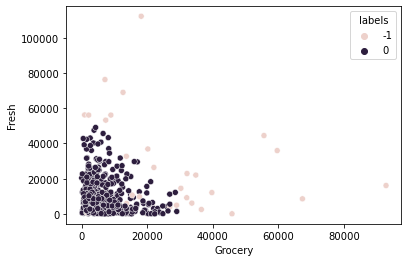

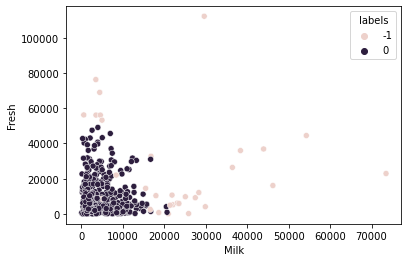

In [10]:
sns.scatterplot(df.Grocery, df.Fresh, hue=df.labels)
plt.show()

sns.scatterplot(df.Milk, df.Fresh, hue=df.labels)
plt.show()

# Exercise
* Clustering - DBSCAN

# Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.


In [11]:
#get subset of features for scaling and scanning
columns = ["Frozen", "Detergents_Paper", "Delicassen"]
frozen_det_deli = df[columns]

In [12]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(frozen_det_deli)

# Use the scaler
frozen_det_deli = scaler.transform(frozen_det_deli)


In [13]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(frozen_det_deli)

DBSCAN(eps=0.1, min_samples=20)

In [14]:
# Now, let's add the scaled value columns back onto the dataframe
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(frozen_det_deli, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Milk,Scaled_Fresh,labels,Scaled_Frozen,Scaled_Detergents_Paper,Scaled_Delicassen
0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.130727,0.112940,0,0.003106,0.065427,0.027847
1,2,3,7057,9810,9568,1762,3293,1776,0.103097,0.132824,0.062899,0,0.028548,0.080590,0.036984
2,2,3,6353,8808,7684,2405,3516,7844,0.082790,0.119181,0.056622,0,0.039116,0.086052,0.163559
3,1,3,13265,1196,4221,6404,507,1788,0.045464,0.015536,0.118254,0,0.104842,0.012346,0.037234
4,2,3,22615,5410,7198,3915,1777,5185,0.077552,0.072914,0.201626,0,0.063934,0.043455,0.108093


In [15]:
# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers
df['labels_b'] = dbsc.labels_
df.labels.value_counts()

 0    409
-1     31
Name: labels, dtype: int64

In [16]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Milk,Scaled_Fresh,labels,Scaled_Frozen,Scaled_Detergents_Paper,Scaled_Delicassen,labels_b
0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.130727,0.112940,0,0.003106,0.065427,0.027847,0
1,2,3,7057,9810,9568,1762,3293,1776,0.103097,0.132824,0.062899,0,0.028548,0.080590,0.036984,0
2,2,3,6353,8808,7684,2405,3516,7844,0.082790,0.119181,0.056622,0,0.039116,0.086052,0.163559,0
3,1,3,13265,1196,4221,6404,507,1788,0.045464,0.015536,0.118254,0,0.104842,0.012346,0.037234,0
4,2,3,22615,5410,7198,3915,1777,5185,0.077552,0.072914,0.201626,0,0.063934,0.043455,0.108093,0


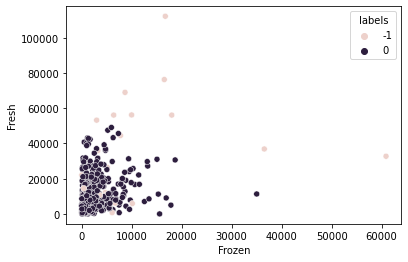

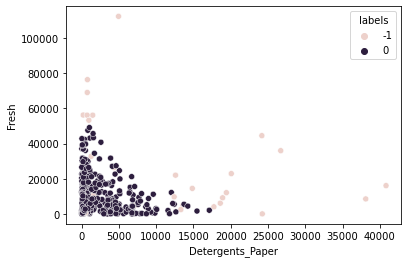

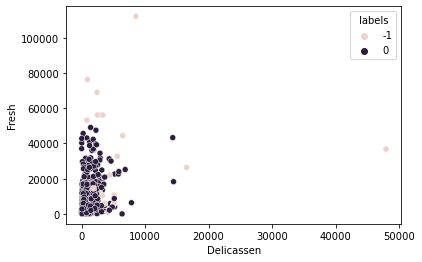

In [19]:
sns.scatterplot(df.Frozen, df.Fresh, hue=df.labels)
plt.show()

sns.scatterplot(df.Detergents_Paper, df.Fresh, hue=df.labels)
plt.show()

sns.scatterplot(df.Delicassen, df.Fresh, hue=df.labels)
plt.show()

# Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.


# Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).